In [2]:
#Imports
import os
import pandas as pd
import nltk
import string
import gensim
import timeit
import numpy as np
from gensim import corpora, models, similarities

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import FreqDist
from nltk import bigrams
from nltk import word_tokenize
from nltk import tokenize

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Reading and Cleaning

In [2]:
fakenews_df = pd.read_csv("fake.csv")
fake_real_df = pd.read_csv("fake_and_real_news.csv")

In [3]:
len(fakenews_df)

12999

In [4]:
len(fake_real_df)

6335

In [5]:
fakenews_df =  fakenews_df.drop(['author','domain_rank','main_img_url'], axis=1) 

In [6]:
fakenews_df = fakenews_df.dropna(subset=['title','text'])

In [7]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token
                token = token.strip('»') if self.strip else token
                token = token.strip('…') if self.strip else token
                token = token.strip('“') if self.strip else token
                token = token.strip('’') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue
                  
                # If digit, ignore token and continue
                if token.isdigit():
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

preprocessor = NLTKPreprocessor()

In [ ]:
fakenews_df['pre_title'] = preprocessor.fit_transform([title for title in fakenews_df.title])

In [ ]:
fakenews_df['pre_text'] = preprocessor.fit_transform([text for text in fakenews_df.text])

In [ ]:
fake_real_df['pre_title'] = preprocessor.fit_transform([title for title in fake_real_df.title])

In [ ]:
fake_real_df['pre_text'] = preprocessor.fit_transform([text for text in fake_real_df.text])

In [ ]:
fakenews_df.to_csv('fakenews_processed.csv')

In [ ]:
fake_real_df.to_csv('fake_real_processed.csv')

### Create text corpus for training word2vec

In [3]:
# Reload saved processed data
fake_real_df = pd.read_csv("src/fake_real_processed.csv")
fakenews_df = pd.read_csv("src/fakenews_processed.csv")

### Combine text into one big string

In [4]:
raw_fake = [x for x in fakenews_df['text']]

In [5]:
raw_fake = "".join(raw_fake)

In [6]:
# Token setting 
pattern = r'''(?x)  # set flag to allow verbose regexps
(?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
|\w+(?:[-']\w+)*    # words with optional internal hyphens
|\$?\d+(?:\.\d+)?   # currency, e.g. $12.80 
|\.\.\.             # elipses
|[.,;"'?()-_`]      # these are separate tokens
'''

In [7]:
tokenized_raw =" ".join( nltk.regexp_tokenize(raw_fake,pattern))

In [8]:
tokenized_raw=tokenize.sent_tokenize(tokenized_raw)

In [9]:
nopunct=[]
for sent in tokenized_raw:
        a = [w for w in sent.split() if w not in string.punctuation]
        nopunct.append(" ".join(a))

#word list
tok_corp = [nltk.word_tokenize(sent) for sent in nopunct]

In [10]:
# Unique Words in text
combined_list = [" ".join(w) for w in tok_corp]
unique_list = []
for sent in combined_list:
    unique_list.append([w for w in sent.split()])
unique_list=list(set([item for sublist in unique_list for item in sublist]))

In [13]:
# training gensim on corpus
fake_model = gensim.models.Word2Vec(tok_corp, min_count=1, size = 16, window=5)

2017-04-27 21:07:09,465 : DEBUG : Fast version of gensim.models.word2vec is being used
2017-04-27 21:07:09,467 : INFO : collecting all words and their counts
2017-04-27 21:07:09,468 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-27 21:07:09,524 : INFO : PROGRESS: at sentence #10000, processed 210655 words, keeping 21349 word types
2017-04-27 21:07:09,583 : INFO : PROGRESS: at sentence #20000, processed 432453 words, keeping 30710 word types
2017-04-27 21:07:09,647 : INFO : PROGRESS: at sentence #30000, processed 655137 words, keeping 35965 word types
2017-04-27 21:07:09,704 : INFO : PROGRESS: at sentence #40000, processed 864748 words, keeping 42263 word types
2017-04-27 21:07:09,760 : INFO : PROGRESS: at sentence #50000, processed 1080840 words, keeping 47208 word types
2017-04-27 21:07:09,816 : INFO : PROGRESS: at sentence #60000, processed 1298931 words, keeping 53473 word types
2017-04-27 21:07:09,869 : INFO : PROGRESS: at sentence #70000, proces

In [22]:
fake_model.save('fake_model.model')

2017-04-27 21:23:21,662 : INFO : saving Word2Vec object under fake_model.model, separately None
2017-04-27 21:23:21,666 : INFO : not storing attribute syn0norm
2017-04-27 21:23:21,667 : INFO : not storing attribute cum_table
2017-04-27 21:23:23,386 : INFO : saved fake_model.model


In [14]:
google_model = gensim.models.KeyedVectors.load_word2vec_format('src/GoogleNews-vectors-negative300.bin', binary=True)

2017-04-27 20:18:42,478 : INFO : loading projection weights from src/GoogleNews-vectors-negative300.bin
2017-04-27 20:19:23,240 : INFO : loaded (3000000, 300) matrix from src/GoogleNews-vectors-negative300.bin


### Fun with Vectors

In [12]:
fake_model.most_similar(positive=['government'], negative=['rights'], topn=5)

[('andAlias', 0.7759290933609009),
 ('Fundación', 0.7756687998771667),
 ('10.6', 0.7672945261001587),
 ('TopicsCorrente', 0.754002571105957),
 ('investigation', 0.7502084970474243)]

In [ ]:
# TODO: write text process to compare, print embeddings

In [16]:
google_model.most_similar(positive=['King',"woman"],negative=['man'], topn=5)

2017-04-27 20:22:04,928 : INFO : precomputing L2-norms of word weight vectors


[('Queen', 0.5515626072883606),
 ('Oprah_BFF_Gayle', 0.47597551345825195),
 ('Geoffrey_Rush_Exit', 0.46460169553756714),
 ('Princess', 0.4533674716949463),
 ('Yvonne_Stickney', 0.4507041275501251)]

### Dimensionality Reduction

In [14]:
## List of Vectors for unique words in text
vectors_list = []
for word in unique_list:
    vectors_list.append(fake_model[word])

In [15]:
# BUG: kernel crashes with too many vectors (most tried: ~20,000)
len(vectors_list)

202933

In [17]:
# Subsample vectors list
vectors_list_sample = vectors_list[::10]

In [18]:
data_embed=TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(vectors_list_sample)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 20294
[t-SNE] Computed conditional probabilities for sample 2000 / 20294
[t-SNE] Computed conditional probabilities for sample 3000 / 20294
[t-SNE] Computed conditional probabilities for sample 4000 / 20294
[t-SNE] Computed conditional probabilities for sample 5000 / 20294
[t-SNE] Computed conditional probabilities for sample 6000 / 20294
[t-SNE] Computed conditional probabilities for sample 7000 / 20294
[t-SNE] Computed conditional probabilities for sample 8000 / 20294
[t-SNE] Computed conditional probabilities for sample 9000 / 20294
[t-SNE] Computed conditional probabilities for sample 10000 / 20294
[t-SNE] Computed conditional probabilities for sample 11000 / 20294
[t-SNE] Computed conditional probabilities for sample 12000 / 20294
[t-SNE] Computed conditional probabilities for sample 13000 / 20294
[t-SNE] Computed conditional probabilities

In [19]:
x_axis = data_embed[:,0]
y_axis = data_embed[:,1]

In [20]:
plt.scatter(x_axis, y_axis, s=1)

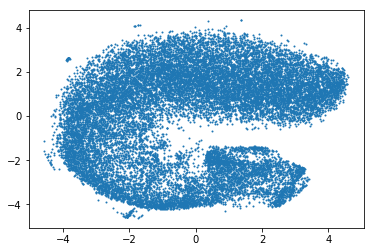

In [21]:
plt.show()

### doc2vec